<a href="https://colab.research.google.com/github/stevengregori92/Learn-XGBoost-with-Feature-Importance/blob/main/Train_Stock_with_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install luwiji
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.3 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.1-py2.py3-none-any.whl size=40366830 sha256=cae0f07ac345643e7af8719767b3d98225028e8be66a484dd6e823e8ffa228e0
  Stored in directory: /root/.cache/pip/wheels/ba/90/9e/943ac5067e9cdc185d8f029a1d13278acd52839118acc06c9a
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32178 sha256=7355a3abf6fe87e68d7093c0d68585d9ea23cb557eb11ec765f6f230718f2716
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built luwiji jcopml
Looking in indexes: 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.plot import plot_missing_value

#Import Dataset

In [5]:
!gdown https://drive.google.com/uc?id=1m9gh1ciOLGegpbnCEi1vX7tIYlus99Xy

Downloading...
From: https://drive.google.com/uc?id=1m9gh1ciOLGegpbnCEi1vX7tIYlus99Xy
To: /content/stock.zip
100% 4.78M/4.78M [00:00<00:00, 9.68MB/s]


In [6]:
!unzip /content/stock.zip

Archive:  /content/stock.zip
  inflating: indexData.csv           
  inflating: indexInfo.csv           
  inflating: indexProcessed.csv      


In [20]:
df = pd.read_csv('indexData.csv', parse_dates=['Date'], index_col='Date')
df

,Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1965-12-31,NYA,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1966-01-03,NYA,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
1966-01-04,NYA,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
1966-01-05,NYA,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
1966-01-06,NYA,532.070007,532.070007,532.070007,532.070007,532.070007,0.0
...,...,...,...,...,...,...,...
2021-05-27,N100,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,379696400.0
2021-05-28,N100,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,160773400.0
2021-05-31,N100,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,91173700.0


#Cleaning Data

,missing_value,%
Index,0,0.00
Open,2204,1.96
High,2204,1.96
Low,2204,1.96
Close,2204,1.96
Adj Close,2204,1.96
Volume,2204,1.96


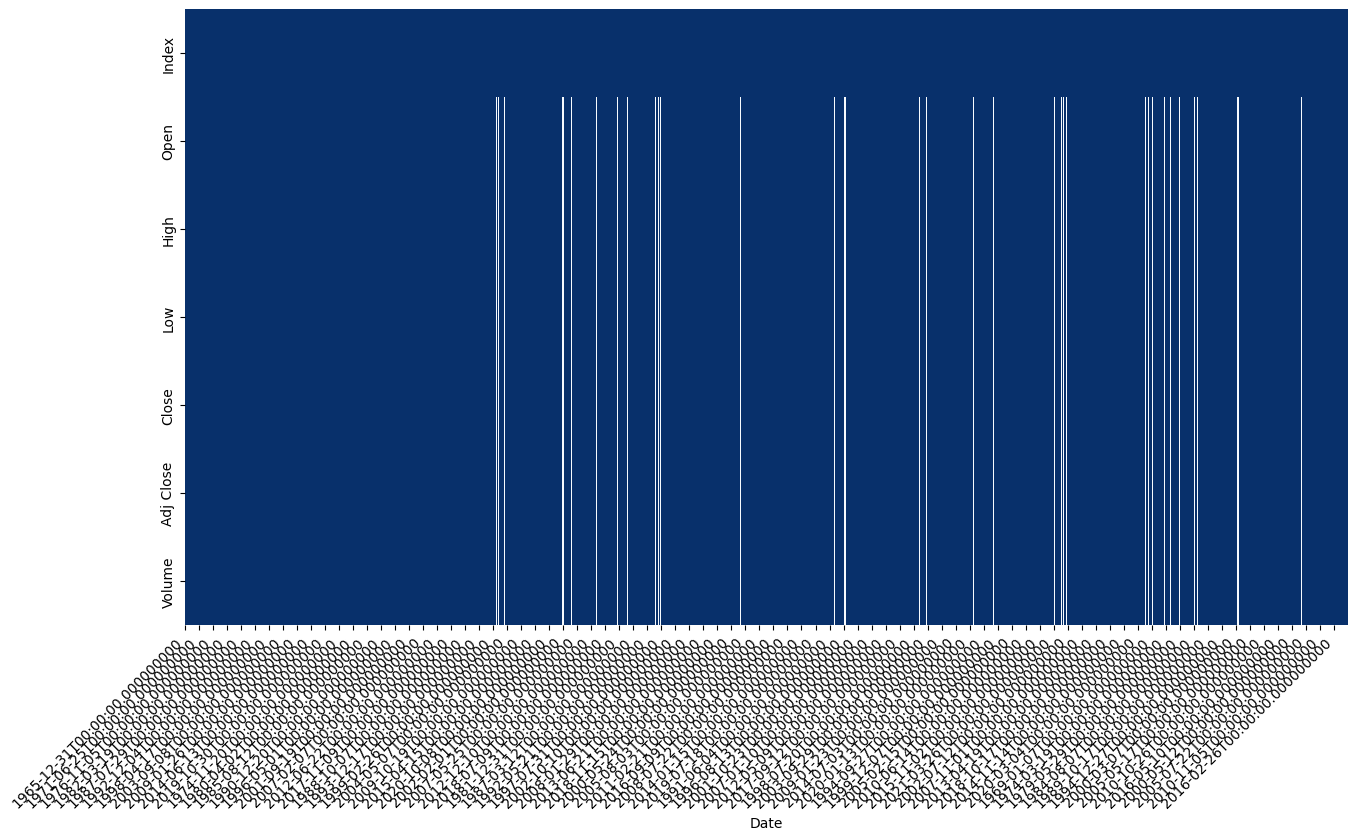

In [21]:
plot_missing_value(df, return_df=True)

In [28]:
df['Close'] = df['Close'].fillna(df['Close'].mean())

#Data Splitting

In [30]:
X = df.drop(columns='Close')
y = df.Close

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89965, 6), (22492, 6), (89965,), (22492,))

#Data Modelling

In [35]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [36]:
X_train.columns

Index(['Index', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], dtype='object')

In [37]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['Open', 'High', 'Low', 'Adj Close', 'Volume']),
    ('categoric', cat_pipe(encoder='onehot'), ['Index'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs = -1, random_state = 42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'algo__colsample_bytree': 0.48419826850829517, 'algo__gamma': 7, 'algo__learning_rate': 0.12500605008148558, 'algo__max_depth': 8, 'algo__n_estimators': 180, 'algo__reg_alpha': 0.03311513223960379, 'algo__reg_lambda': 0.8124773120579367, 'algo__subsample': 0.5155212390864478}
0.9999869026067711 0.9999578235212483 0.9999749568582955


#Feature Importance

In [38]:
from jcopml.feature_importance import mean_score_decrease

,feature,importance,stdev
2,High,0.305163,8.580218e-04
4,Adj Close,0.293098,7.518175e-04
3,Low,0.061629,1.488329e-04
0,Index,0.005708,1.223885e-05
1,Open,0.001461,5.740907e-06
5,Volume,0.000113,3.000471e-07


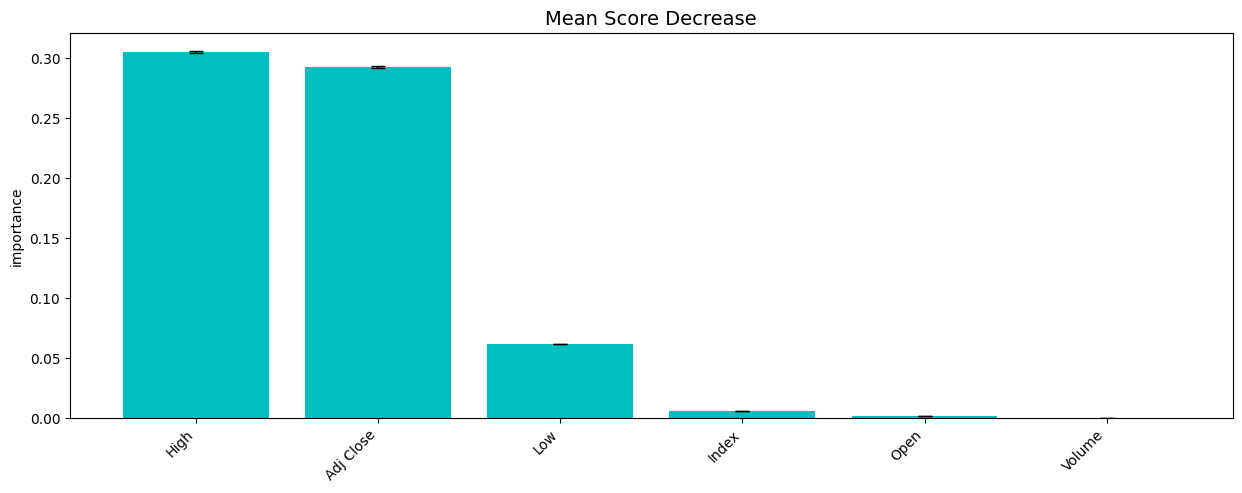

In [39]:
mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [40]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['High', 'Low', 'Adj Close'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs = -1, random_state = 42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'algo__colsample_bytree': 0.5447683338642672, 'algo__gamma': 1, 'algo__learning_rate': 0.04611516890368919, 'algo__max_depth': 6, 'algo__n_estimators': 195, 'algo__reg_alpha': 0.0615202028217668, 'algo__reg_lambda': 0.0024128291259039305, 'algo__subsample': 0.6280655987471175}
0.9999821891083343 0.9999709475368045 0.9999731993409329
